In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
from nilearn.image import resample_img
import skimage.transform as skTrans

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

In [2]:
import fastai; fastai.__version__

'2.5.3'

In [3]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [4]:
# Create a meta file for nii files processing

path_to_input = 'Test_Batch'

file_list = []

for dirname, _, filenames in os.walk(path_to_input):
    for filename in filenames:
        file_list.append((dirname,filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    
df_files[0:50]



,dirname,filename
0,Test_Batch,test-volume-0.nii
1,Test_Batch,test-volume-1.nii
2,Test_Batch,test-volume-10.nii
3,Test_Batch,test-volume-11.nii
4,Test_Batch,test-volume-12.nii
5,Test_Batch,test-volume-13.nii
6,Test_Batch,test-volume-14.nii
7,Test_Batch,test-volume-15.nii
8,Test_Batch,test-volume-16.nii
9,Test_Batch,test-volume-17.nii


In [5]:
# Map CT scan and label

for i in range(131):
    ct = f"test-volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    df_files.loc[df_files['filename'] == ct]

# drop segment rows
print(len(df_files))
df_files

70


,dirname,filename
0,Test_Batch,test-volume-0.nii
1,Test_Batch,test-volume-1.nii
2,Test_Batch,test-volume-10.nii
3,Test_Batch,test-volume-11.nii
4,Test_Batch,test-volume-12.nii
...,...,...
65,Test_Batch,test-volume-68.nii
66,Test_Batch,test-volume-69.nii
67,Test_Batch,test-volume-7.nii
68,Test_Batch,test-volume-8.nii


In [6]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
#     array   = np.array(array)
    array   = np.rot90(np.array(array))
    return(array)

In [7]:
#read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
# downsampled_ct = resample_img(sample_ct, target_affine=np.eye(3)*2., interpolation='nearest')
# downsampled_mask = resample_img(sample_mask, target_affine=np.eye(3)*2., interpolation='nearest')
print(sample_ct.shape) 
print(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])

(512, 512, 163)
Test_Batch/test-volume-0.nii


In [8]:
# #read sample
# sample = 38
# sample_ct   = read_nii(f"../input/lits17-test-data"+'/'+df_files.loc[sample,'filename'])
# # downsampled_ct = skTrans.resize(sample_ct, (512,512,sample_ct.shape[2]), order=1, preserve_range=True)
# # downsampled_ct = resample_img(sample_ct, target_affine=np.eye(3)*2., interpolation='continuous')
# sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
# # downsampled_mask = skTrans.resize(sample_mask, (512,512,sample_mask.shape[2]), order=1, preserve_range=True)
# # downsampled_mask = resample_img(sample_mask, target_affine=np.eye(3)*2., interpolation='continuous')
# print(sample_ct.shape) 
# # print(downsampled_ct.shape) 
# print(sample_mask.shape)
# # print(downsampled_mask.shape) 
# print(f"../input/lits17-test-data"+'/'+df_files.loc[sample,'filename'])

In [9]:
print(np.amin(sample_ct), np.amax(sample_ct))


-1024.0 2631.0


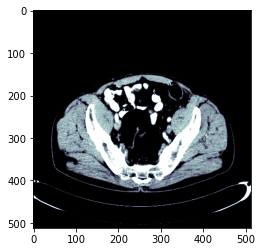

In [10]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [11]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,3,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,3,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')

    
    plt.subplot(1,3,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

IndexError: list index out of range

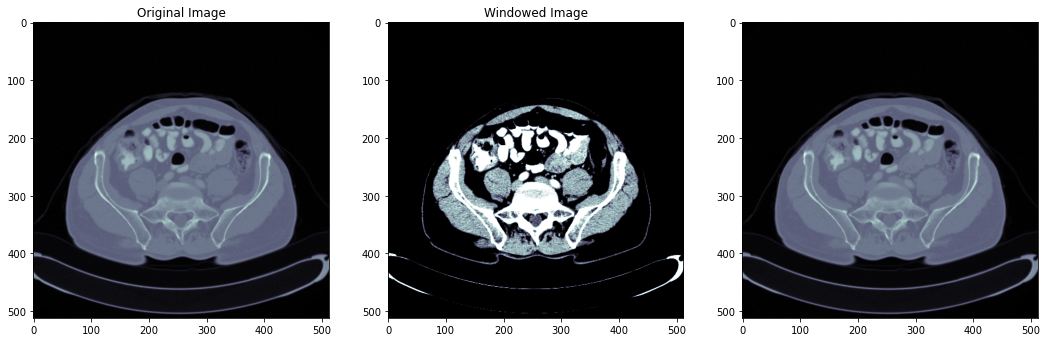

In [12]:
sample=67
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

# plot_sample([sample_ct[...,sample]])
plot_sample([sample_ct[...,sample]])

In [ ]:
# # Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
# mask_resized = mask.resize((256,256))
#downsample_ct = skTrans.resize(curr_ct, (256,256,curr_ct.shape[2]), order=1, preserve_range=True)
# mask = skTrans.resize(mask, (256,256), order=1, preserve_range=True)
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)
plt.imshow(mask , cmap = 'bone')

<AxesSubplot:>

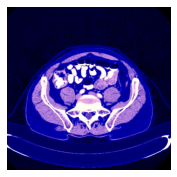

In [13]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

@patch
def save_jpg_512x512(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im = im.rotate(angle = 270)
    im.save(fn, quality=quality)

    
@patch
def save_jpg_256x256(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im = im.resize((256,256))
    im = im.rotate(angle = 270)
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])


In [14]:
GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h
slice_sum=0
if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('test_images',exist_ok=True)

    for ii in tqdm(range(0,len(df_files))): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        # curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])

        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        slice_sum = slice_sum+curr_dim

        for curr_slice in range(0,curr_dim,1): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            data.save_jpg_512x512(f"test_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])

            # mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            # mask = mask.rotate(angle=270)
            # mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}.tiff")
            #
else:
    
    path = Path("liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

print(slice_sum)


  0%|          | 0/70 [00:00<?, ?it/s]

26608


In [ ]:
!zip -q -r train_masks.zip "./train_masks"
!zip -q -r train_images.zip "./train_images"

In [ ]:
# !rm -rf ./train_images
# !rm -rf ./train_masks